In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Loading in Pytorch EO

## Introduction

Pytorch EO is designed to work with any combination of inputs-outputs to enable applications such as unsupervised learning (no outputs), data fusion (multiple inputs), multi task learning (multiple outputs) and any other combination.

To do so we define Pytorch `Datasets` for each input and output modality (i.e images and metadata for inputs and labels, bounding boxes, masks, etc, for outputs). For training, we create a `ConcatDataset` to iterate over the desired combination of inputs-outputs.

Our design philosophy is to load data as `numpy` arrays. For images, we keep channels last.

## Basic Data Loading

The following code will download the EuroSAT dataset RGB version (small and fast).

In [67]:
import os
from pytorch_eo.utils import download_url, unzip_file
from pathlib import Path

path = Path('data')
os.makedirs(path, exist_ok=True)

url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
compressed_data_filename = 'EuroSAT.zip'
compressed_data_path = path / compressed_data_filename
download_url(url, compressed_data_path)

unzip_file(compressed_data_path, path, msg="extracting data ...")

extracting data ...: 100%|██████████| 27011/27011 [00:02<00:00, 10663.60it/s]


Now we can find our images and labels. Each dataset may have its own pre-processing steps, in this case the labels are encoded in the folder name and images can be found inside each folder.

In [68]:
data_folder = '2750'
uncompressed_data_path = path / data_folder
classes = sorted(os.listdir(uncompressed_data_path))
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

On our pre-defined datasets, this functionality is implemented in the `setup` method of the corresponding `LightningDataModule`. Nevertheless, we will always end up with the same: a list of paths to images and the corresponding labels (or bounding boxes, segmentation masks, ...), pairs of inputs-outputs to feed and train our model.

In [69]:
import pandas as pd

images, labels = [], []
for ix, label in enumerate(classes):
    _images = os.listdir(uncompressed_data_path / label)
    images += [str(uncompressed_data_path /
                label / img) for img in _images]
    labels += [ix]*len(_images)

df = pd.DataFrame({'image': images, 'label': labels})

df.sample(5)

,image,label
18161,data/2750/PermanentCrop/PermanentCrop_2493.jpg,6
16264,data/2750/PermanentCrop/PermanentCrop_893.jpg,6
13127,data/2750/Industrial/Industrial_1365.jpg,4
13222,data/2750/Industrial/Industrial_1679.jpg,4
8010,data/2750/HerbaceousVegetation/HerbaceousVeget...,2


The next step consists on creating the `Datasets` for each field. We will use `RGBImageDataset` for images and the raw `Numpy` array of labels.

In [70]:
from pytorch_eo.datasets import RGBImageDataset

images_ds = RGBImageDataset(images)

len(images_ds)

27000

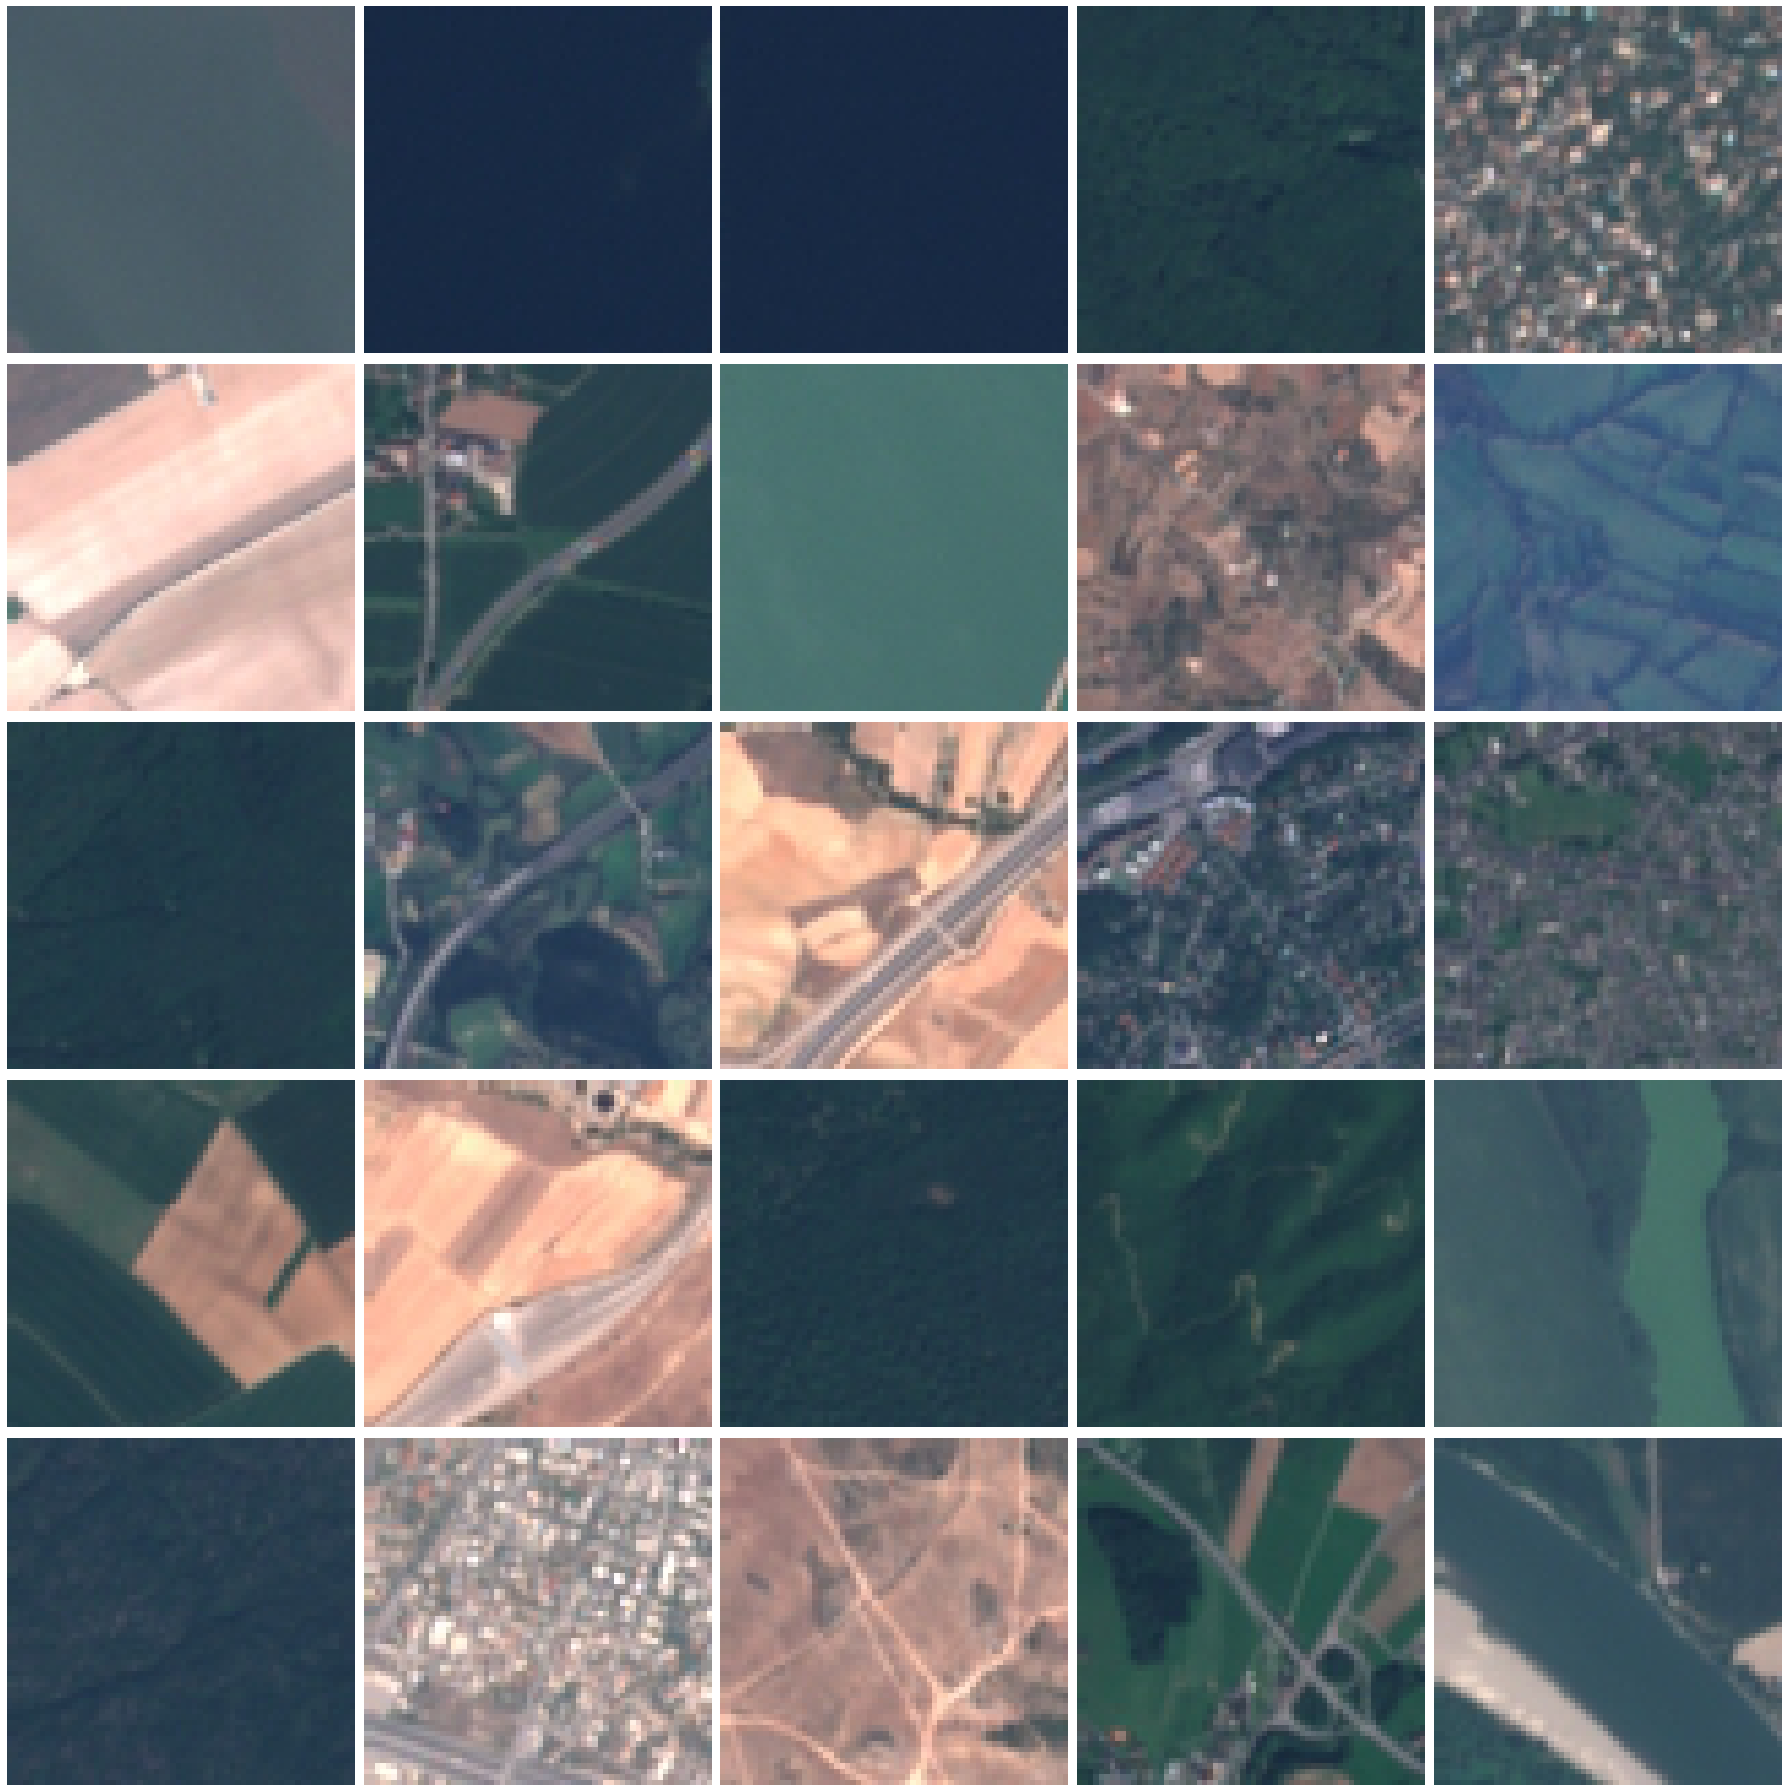

In [71]:
import random 
import matplotlib.pyplot as plt

r, c = 5, 5
fig = plt.figure(figsize=(5*c, 5*r))
for i in range(r):
	for j in range(c):
		ix = random.randint(0, len(images_ds))
		img = images_ds[ix]
		ax = plt.subplot(5, 5, i*5+j+1)
		ax.imshow(img)
		ax.axis('off')
plt.tight_layout()
plt.show()

In [72]:
# Pytorch allows raw numpy arrays as datasets :)

labels_ds = labels

len(labels_ds)

27000

In order to train a model for a classification task, we need the images and the corresponding labels. For that, we have to create a `ConcatDataset` passing a `dict` with the names of the datasets and the datasets themselves (we will use the names in the future for other things).

In [73]:
from pytorch_eo.datasets import ConcatDataset

ds = ConcatDataset({'image': images_ds, 'label': labels_ds})

len(ds)

27000

The dataset will contain all the available samples. We can retrieve them by their keys.

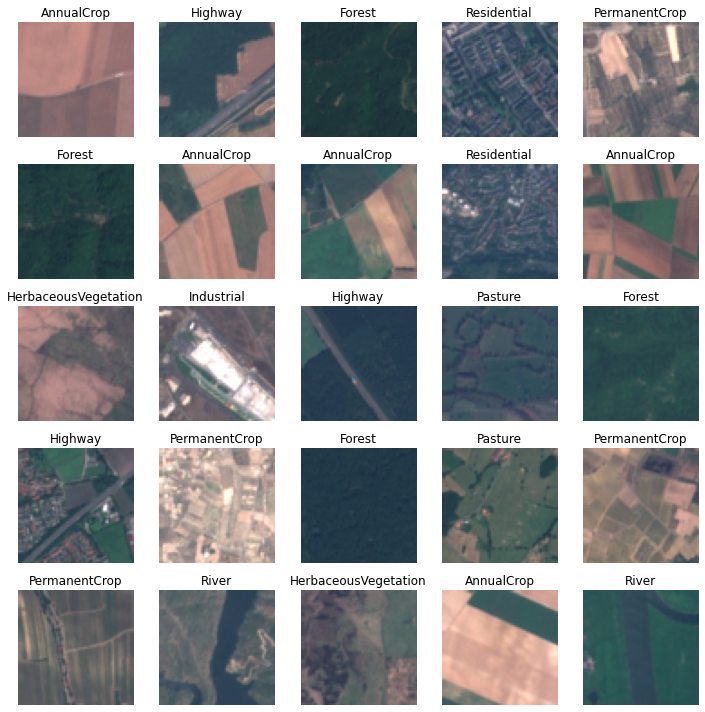

In [74]:
r, c = 5, 5
fig = plt.figure(figsize=(2*c, 2*r))
for i in range(r):
	for j in range(c):
		ix = random.randint(0, len(images_ds))
		sample = ds[ix]
		img, label = sample['image'], sample['label']
		ax = plt.subplot(5, 5, i*5+j+1)
		ax.imshow(img)
		ax.set_title(classes[label])
		ax.axis('off')
plt.tight_layout()
plt.show()

The next step is to create the `DataLoader`. This is the object responsible for efficiently loading data and batching it. Data is now in the `tensor` format.

In [75]:
from torch.utils.data import DataLoader

dl = DataLoader(ds, batch_size=5, shuffle=True)

batch = next(iter(dl))
imgs, labels = batch['image'], batch['label']

imgs.shape, imgs.dtype, labels.shape, labels.dtype

(torch.Size([5, 64, 64, 3]), torch.uint8, torch.Size([5]), torch.int64)

In [76]:
def plot_batch(batch):
    imgs, labels = batch['image'], batch['label']
    fig = plt.figure(figsize=(2*len(imgs), 5))
    for ix, (img, label) in enumerate(zip(imgs, labels)):
        ax = plt.subplot(1,len(imgs), ix + 1)
        ax.imshow(img)
        ax.set_title(classes[label.item()])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

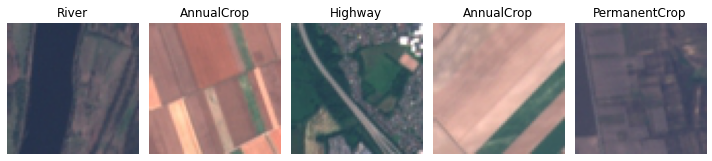

In [79]:
batch = next(iter(dl))
plot_batch(batch)

This is the basis of data loading in Pytorch EO. Use this information to build your own Datasets.